# Redes neuronales 5

En la primera clase práctica de la asignatura, cuando aún podíamos salir a la calle, reflexionamos sobre la complejidad que tiene el proceso de la visión. ¿Cuántas imágenes distintas podríamos formar en una matriz de bytes de $100 \times 100$? La respuesta es: $2^{80000}$. ¿Son muchas? Muchísimas, a efectos prácticos, infinitas.

Sin embargo, vimos una aplicación en el móvil que, sin esfuerzo aparente y de forma casi mágica, podía determinar qué tipo de objeto aparecía delante de la cámara. Nosotros mismos somos capaces de reconocer los objetos que aparecen delante de nuestros ojos sin que nos cueste un dolor de cabeza. 

¿Cómo es capaz nuestro cerebro de procesar tan rápidamente la enorme cantidad de estímulos luminosos que llegan a nuestra retina? No lo sabemos con exactitud. Sí sabemos que son integrados de forma secuencial en diferentes capas neuronales construyendo en cada paso representaciones más complejas de la información.

Esa idea nos sirve de inspiración para construir redes neuronales que sean capaces de “ver”. A continuación, vamos a estudiar qué procesos y técnicas nos permiten pasar de la magia a la ingeniería.

	

> Cualquier tecnología lo suficientemente avanzada es indistinguible de la magia. Arthur C. Clarke.

## Convolución

Antes de meternos de lleno en las redes, necesitamos comprender bien el concepto de **convolución**. La convolución es un operador matemático que se define como la integral del producto de dos funciones donde una de ellas está desplazada una distancia $t$.

$$ (f \ast g)(t) = \int_{-\infty}^{\infty} f(x)g(t-x) dx  $$

Nosotros vamos a adaptar este operador a una versión bidimensional y discreta. Esta sería la versión bidimensional:

$$ (f \ast g)(i,j) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} f(x,y)g(i-x,j-y) dx  $$

Y esta la versión bidimensional y discreta con paso 1, que es la que nos interesa:

$$ (f \ast g)(i,j) = \sum_{-\infty}^{\infty} \sum_{-\infty}^{\infty} f(x,y)g(i-x,j-y)$$


¿Y para qué nos va a servir? Antes habíamos dicho que nuestro cerebro integraba simples estímulos visuales procedentes de cada fotorreceptor de la retina para producir elementos de información cada vez más compleja y elaborada para permitir luego su reconocimiento. Es como decir que para reconocer una cara nuestro sistema visual registra primero fragmentos de la imagen como pupilas, comisuras de labios, lóbulos de orejas… para luego formar ojos, bocas, orejas… para, finalmente, formar caras. Bueno, pues con la operación de convolución vamos a hacer algo así.


Partamos de una imagen cualquiera, tomémosla en escala de grises para que sea aún más sencilla. Por ahora solo tenemos pixeles. ¿Cuáles serían las características más sencillas que podríamos encontrar? Quizá serían las características que encontraríamos en regiones de tamaño $3 \times 3$ de la imagen. ¿Qué cabe en una región tan pequeña? Podríamos encontrar un borde vertical, un borde horizontal, una esquina, un punto… cosas así. 

Echemos un vistazo de nuevo a la expresión de la convolución en su versión bidimensional  y discreta y hagámosle unas adaptaciones. En primer lugar, démosle sentido a $g$. Esta función va a ser nuestra imagen. La función $f$ va a ser otra imagen, pero en este caso, de tamaño $3 \times 3$. Además le vamos a cambiar el nombre y, a partir de ahora, la llamaremos **kernel**. Le asignaremos estos valores: 

\begin{bmatrix}
 1 & 0 & -1\\ 
 1 & 0 & -1\\ 
 1& 0 & -1
\end{bmatrix}

Puesto que el kernel es de tamaño $3 \times 3$ los índices de los sumatorios serán:

$$ conv2D(i,j) = \sum_{y=0}^{2} \sum_{x=0}^{2} kernel(x,y) \cdot imagen(i-x,j-y)$$

Y para hacerlo un poco más interpretable, simplemente vamos a cambiar la manera en que superponemos el kernel sobre la imagen cambiando restas por sumas:

$$ conv2D(i,j) = \sum_{y=0}^{2} \sum_{x=0}^{2} kernel(x,y) \cdot imagen(i+x,j+y)$$

Vamos a visualizarlo con un ejemplo. Nuestra imagen es de $6 \times 6$ y tiene los valores que representa la figura.


<img src="imgs/Kernel.svg" width="50%">

Queremos calcular el valor de la convolución en las coordenadas (2,1). Gráficamente se vería como la superposición del kernel sobre la imagen en esas coordendas y multiplicar celda a celda sus correspondientes valores para, finalmente, sumarlo todo. El resultado que nos devuelve es 765. Es decir, un valor alto. ¿Qué pasaría si el área de $3 \times 3$ de la imagen sobre la que superponemos el kernel fuera totalmente homogénea? Efectivamente, el resultado sería 0. *Voilà*, ya tenemos un detector de bordes verticales.

<img src="imgs/Kernel2.svg" width="30%">

#### Ejercicios

- Construye un kernel para detectar bordes horizontales.
- En el ejemplo gráfico anterior, si la imagen es de tamaño $6 \times 6$ y el kernel $3 \times 3$ ¿Qué tamaño tiene la imagen resultante de haber pasado completamente el kernel por toda la imagen? 

## Implementación de la convolución

Vamos a llevar todo esto a código para despejar cualquier duda que aún podamos tener. Utilizaremos una imagen de prueba para implementar una versión sencilla de la convolución usando diversos kernels.

Dimensiones de la imagen: (32, 32)
Máximo valor: 1.0
Mínimo valor: 0.0


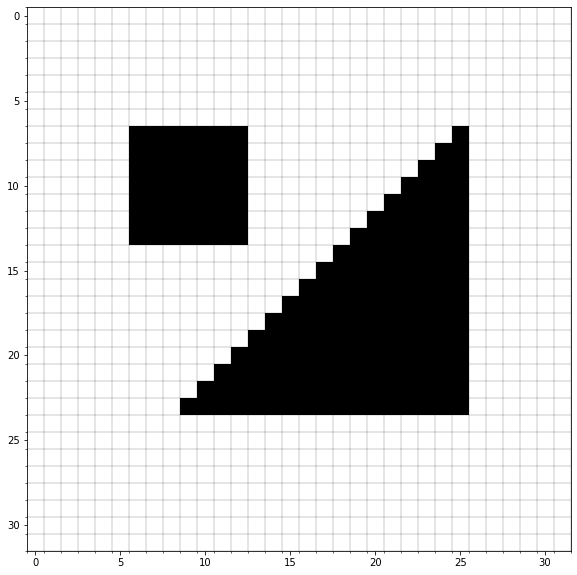

In [2]:
import matplotlib.pyplot as plt
from skimage import io

%matplotlib inline

plt.rcParams['image.cmap'] = 'gray'
image=io.imread("imgs/figuras.png")/255.0 # imread lee las imagenes con los pixeles codificados como enteros 
# en el rango 0-255. Por eso la convertimos a flotante y en el rango 0-1

print("Dimensiones de la imagen:", image.shape)
print("Máximo valor:", image.max())
print("Mínimo valor:", image.min())

plt.figure(figsize=(20,10))
plt.imshow(image)

ax = plt.gca();
ax.set_xticks(np.arange(-.5, 32, 1), minor=True);
ax.set_yticks(np.arange(-.5, 32, 1), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=0.2)

Dimensiones de la imagen: (32, 32)
Máximo valor: 3.0
Mínimo valor: -3.0


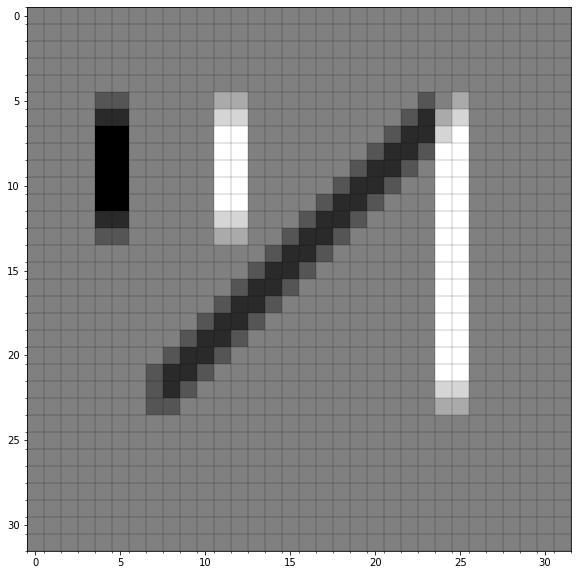

In [3]:
import numpy as np

# Valores del kernel
values = np.array([[-1., 0., 1.],[-1., 0., 1.],[-1., 0., 1.]]) # Detector de bordes verticales
#weights = np.array([[-1., -1., -1.],[0., 0., 0.],[1., 1., 1.]]) # Detector de bordes horizontales
#weights = np.array([[-2., -1., 0.],[-1., 0., 1.],[0., 1., 2.]]) # Detector de bordes diagonales


# Convolución
def convolution(image, kernel):
    result = np.zeros((image.shape[0],image.shape[1]), dtype=float)
    
    # Recorrido de la imagen
    for j in range(0, image.shape[0]-2):
        for i in range(0, image.shape[1]-2):
            aux = 0
            # Recorrido del kernel
            for m in range(0, values.shape[0]):
                for n in range(0, values.shape[1]):
                    aux += image[j+m][i+n] * values[m][n] 
            result[j][i] = aux
    return result

image_result = convolution(image, values)

print("Dimensiones de la imagen:", image_result.shape)
print("Máximo valor:", image_result.max())
print("Mínimo valor:", image_result.min())

plt.figure(figsize=(20,10))
plt.imshow(image_result, vmin=-1,vmax=1)

ax = plt.gca();
ax.set_xticks(np.arange(-.5, 32, 1), minor=True);
ax.set_yticks(np.arange(-.5, 32, 1), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=0.2)

plt.imshow(image_result)

### Primeras conclusiones

¿Te has dado cuenta de que la operación de convolución puede ser implementada por una neurona? Los valores del kernel son equivalentes a los pesos de una neurona, la zona de la imagen donde se superpone el kernel son las entradas a la neurona y el sumatorio de la convolución se ejecuta de la misma forma que el sumatorio de la neurona.

Todo esto nos lleva a crear nuevos tipos de capas en las redes: las **capas convolutivas**.

## Capas convolutivas

Las capas de red que hemos visto hasta ahora se denominan *fully connected (fc)* o **totalmente conectadas**. Esto significa que todas las salidas de una capa anterior están conectadas a todas y cada una de las entradas de la capa siguiente. Por ejemplo, si hubiera 25 neuronas en la capa anterior, cada neurona de la capa siguiente tendría 25 entradas (y una más para el *bias*). En las **capas convolutivas** esto ya no es así. Cada neurona de una capa convolutiva está conectada solo a un conjunto de salidas de la capa anterior. Además, las capas convolutivas esperan una disposición bidimensional de las entradas, no lineal. La figura muestra una neurona (esfera azul) con nueve entradas conectada a un grupo local de nueve valores. El cubo azul representa su salida.

<img src="imgs/NeuronaConv.jpg" width="50%">


Cada neurona de una capa convolutiva comparte el mismo conjunto de pesos, por lo que se podría decir que las neuronas de la capa convolutiva se replican de forma matricial a lo largo y ancho de la entrada. En la figura siguiente vemos la conexión de todas las neuronas de la capa convolutiva.

<img src="imgs/CapaCompleta.jpg" width="40%">

Vamos a echar cuentas, fíjate que hay $10\times15 = 150$ entradas distintas, cada neurona tiene un **campo receptivo** de $3\times3=9$ entradas. Si las alineamos a lo largo y ancho para que se cubran todas las entradas tenemos que hay $8\times13=104$ neuronas. ¿Cuántos pesos distintos hay? ¿$104\times9$? ¡¡Nooo!! Solo $9$. Cada neurona comparte el mismo conjunto de pesos, aunque los valores de las entradas son, obviamente, distintos.



Podemos hacer un detector de bordes horizontales, verticales, diagonales, detectores de esquinas, puntos, etc. en función del **kernel** que definamos. Cada “pixel” de esta nueva "imagen" ya no representa  un simple valor de iluminación aislado, representa una pequeña **característica** local del objeto que contenga. Pero con una sola característica no vamos a ir muy lejos, deberíamos tener más. Supongamos que elegimos bordes horizontales, verticales, diagonales hacia la derecha y diagonales hacia la izquierda. Al aplicar estos cuatro filtros, *kernels* o conjuntos de pesos obtendremos cuatro “imágenes” de características nuevas que, convenientemente apiladas, formarán un **tensor** de $4\times8\times13$. Cada arreglo bidimensional de neuronas (representados con un color diferente) posee un conjunto de pesos único y compartido entre todas sus neuronas. Cada arreglo genera un **canal** diferente en la salida (representado por los cubos azules, verdes, rosas y amarillos).

<img src="imgs/4canales.jpg" width="50%">

\- *¿Tensor? ¿Qué es un tensor?* - Los informáticos solemos llamar a un arreglo bidimensional de objetos "*array* bidimensional" o matriz. Cuando el arreglo es tridimensional lo solemos llamar "*array* tridimensional", pero no deberíamos llamarlo matriz tridimensional (eso es una expresión impropia), sino **tensor**. En el argot matemático, físico o ingenieril, cualquier arreglo de valores de tres dimensiones o más se denomina **tensor**.


Tenemos por tanto este tensor formado por diferentes características de la imagen. ¿Podríamos repetir de nuevo este proceso, pero ahora sobre este tensor? Rápidamente nos surgen un par de preguntas: ¿Con qué pesos? ¿Cómo se conectarían ahora las neuronas?  Antes, la imagen de partida era bidimensional, ahora tenemos un tensor tridimensional. 

No olvidemos que estamos utilizando neuronas, y como tales, pueden aprender por ellas mismas su conjunto de pesos, solo se necesita descender por el gradiente de una función de pérdida (ya veremos luego cómo crear esta función). Por tanto, esos pesos que habíamos propuesto para detectar bordes y demás los vamos a dejar libres (“aprendibles”). Esto significa que será la propia red la que se encargue de ver si efectivamente son bordes u otras características las que realmente necesita obtener.

En cuanto a la conexión, será muy parecido a lo anterior. Cada neurona se conectará a una región local en cuanto a la dimensión $x$ e $y$, y a todos los valores del tensor  en la dimensión $z$. Como ilustra la figura, la primera neurona estará conectada a su correspondiente campo receptivo de $4\times3\times3$. Por lo tanto, cada neurona tendrá 36 entradas.

<img src="imgs/9x4cr.jpg" width="40%">

Es muy importante ahora reflexionar sobre lo que contiene la salida de la neurona de la ilustración anterior. Es una combinación lineal de 36 valores, pero cada uno de esos valores es, a su vez, otra combinación lineal de valores anteriores correspondientes a la imagen original y cuyo valor dependía de haber encontrado una determinada característica simple o no. Por tanto, el valor de esta neurona representa haber encontrado una característica más compleja. Quizá una combinación de un borde con una esquina, o un borde más largo… Su campo receptivo sobre la imagen original es de $5\times5$. La imagen siguiente ilustra simplificadamente por qué la última salida depende, en última instancia, de 5 valores de la entrada original.

<img src="imgs/camporeceptivo.svg" width="30%">

De la misma forma que antes, añadimos más canales y obtenemos un nuevo tensor de salida. Si añadimos 8 canales obtendremos un tensor de dimensión 8 en el eje $z$. Igual que antes, si el tensor de entrada tiene como ancho y alto $(m,n)$ el tensor de salida tendrá unas dimensiones $x$ e $y$ de $(m-2,n-2)$.

<img src="imgs/tensor8x6x11.jpg" width="60%">

## Clasificación del MNIST con una red convolutiva

Vamos a componer una red convolutiva para clasificar el conjunto MNIST. Tenemos como entrada una imagen de $28\times28$ pixels en escala de grises. Por tanto, esto es un tensor de $1\times28\times28$. Pasaremos esta entrada por una primera capa convolutiva de 32 filtros, lo cual nos devolverá un tensor de $32\times26\times26$. De nuevo, pasaremos este tensor ahora como entrada a una segunda capa convolutiva con 64 filtros. ¿Por qué 32 y 64 filtros? Bueno, te habrás imaginado ya que son hiperparámetros. El resultado es un tensor de $64\times24\times24$. Lo que estamos haciendo con las sucesivas capas convolutivas es ir extrayendo características cada vez más complejas que faciliten luego la labor de clasifición.

Llegados a este punto, aplanaremos (*flatten*) este tensor a fin de convertirlo en un vector con una dimensión de $64\times24\times24 = 36864$. Ahora podremos alimentar a una capa *fully connected* (FC) de 128 neuronas. Su resultado lo pasaremos finalmente por una última capa *fully connected* de 10 neuronas.
 

<img src="imgs/modelConv.svg" width="80%">

Esta es una aproximación correcta a una red convolutiva, pero no es la práctica habitual. Hay un problema de tamaño. Si nos fijamos en la capa *fully connected* de 128 neuronas veremos que cada neurona tiene 36.864 entradas (1 más si contamos el bias). Lo que hace un total de ¡¡4.718.720 pesos para esa capa!! Para aliviar este enorme flujo de datos se emplean diferentes técnicas. Una de las más comunes es el *maxpolling*.

### Maxpooling

Si interpretamos con detenimiento la información que contiene un tensor, podremos eliminar gran cantidad de datos sin socavar una parte significativa de esta información. Escojamos, por ejemplo, el tensor con dimensión $32 \times 26 \times 26$. El valor de cada celda de este tensor corresponde a haber encontrado una determinada característica en una región concreta de la imagen original. Un valor alto significa que esa característica se encontró muy claramente. Un valor bajo o cercano al cero indica que esa característica no está presente en la correspondiente zona de la imagen. También podríamos decir que encontrar esa característica una celda a la derecha, a la izquierda, arriba o abajo no debería representar mayor inconveniente. *Maxpooling* aprovecha este hecho eliminando el 75% de los datos sin reducir excesivamente la información que contiene el tensor. Para ello se toma cada canal del tensor (es decir, se divide a lo largo del eje $z$) y se agrupan en regiones de $2 \times 2$. De cada grupo se extrae la celda que mayor valor tenga. Al final de este proceso, tendremos un tensor con las dimensiones $x$ e $y$ reducidas a la mitad.

<img src="imgs/MNISTconvolutional-maxpooling.svg" width="100%">


### Dropout

Las redes convolutivas, como todas las demás redes, pueden adolecer de problemas de sobreajuste (*overfitting*). Para solventar esta contrariedad existen varias técnicas que reducen su efecto. Una de las más usadas y efectivas es el <i>**dropout**</i>. Esta técnica consiste en deshabilitar temporalmente un porcentaje aleatorio de las neuronas de una capa. Es decir, durante un cierto tiempo estas neuronas están, pero como si no estuvieran. El conjunto de neuronas que se habilitan y deshabilitan se van alternando aleatoriamente durante el proceso de entrenamiento.  Con esto se consigue que todas las neuronas deban emplearse a fondo para lograr un buen nivel de *accuracy*.

<img src="imgs/dropout.jpg" width="50%">

<div align="center">
<a href="http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf?utm_content=buffer79b43&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer"> Imagen tomada del artículo original</a>
</div>

Por supuesto, el proceso de *dropout* solo se realiza durante el entrenamiento, no en producción.

### ReLU

Hemos visto que a la salida de las neuronas se les aplica una función de activación. Hasta ahora, hemos visto las funciones sigmoide y softmax, pero existen más. Una de ellas es la función **ReLU** (*Rectified Linear Unit*), cuya definición es:

$$ReLU(x) = max(0, x)$$

Lo cual significa que si la entrada es un valor mayor que 0, la salida será ese mismo valor. Pero si la entrada es negativa la salida será 0. Esta es una función predilecta en la composición de redes convolutivas ya que ofrece muy buenos resultados empíricos. Pero, ¿por qué funciona mejor que la función sigmoide? Si observamos el comportamiento de la función sigmoide con valores lejanos al 0 vemos que es una curva casi plana. Esto significa que su derivada en esos puntos es prácticamente 0, con lo que el descenso por el gradiente en esas zonas sería muy lento y, por tanto, el aprendizaje también . Este problema no lo tiene la función ReLU, su derivada en el semieje positivo es siempre 1.  Pero, ¿y qué ocurre con el semieje negativo? Bueno, cuando la salida de la neurona es negativa su paso por la función ReLU la hace 0. Asumimos que la inicialización aleatoria de los pesos hace que, dada una entrada, parte de las neuronas de una capa obtengan salidas negativas y la otra parte positivas. Esto hace que solo las neuronas con salida positiva intervengan en el proceso de representación del resultado, lo cual reduce su complejidad.






## Código

Con todo esto, ya tenemos los elementos necesarios para montar una red convolutiva efectiva. Como ya hemos hecho anteriormente, empezamos cargando y preparando el *dataset* MNIST.

In [21]:
import keras
from keras.datasets import mnist
from matplotlib import pyplot as plt
import numpy as np


batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Orden en el que se presenta el dataset (num de muestras, canales, filas, columnas) o (num de muestras, filas, columnas, canales) 
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### Modelo y entrenamiento

A diferencia del modelo básico anterior que utilzamos para clasificar el *dataset* MNIST, este modelo incluirá capas convolutivas <code>Conv2D</code>, dropout <code>Dropout</code> y funciones de activación ReLU <code>activation='relu'</code>. Al entrenarlo vemos cómo el *accuracy* sobre el conjunto de validación es mayor que en el modelo básico.

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 3s 55us/step - loss: 0.2643 - accuracy: 0.9187 - val_loss: 0.0629 - val_accuracy: 0.9796
Epoch 2/12
60000/60000 [==============================] - 3s 47us/step - loss: 0.0867 - accuracy: 0.9737 - val_loss: 0.0385 - val_accuracy: 0.9864
Epoch 3/12
60000/60000 [==============================] - 3s 47us/step - loss: 0.0646 - accuracy: 0.9807 - val_loss: 0.0345 - val_accuracy: 0.9880
Epoch 4/12
60000/60000 [==============================] - 3s 48us/step - loss: 0.0533 - accuracy: 0.9846 - val_loss: 0.0306 - val_accuracy: 0.9897
Epoch 5/12
60000/60000 [==============================] - 3s 48us/step - loss: 0.0476 - accuracy: 0.9859 - val_loss: 0.0292 - val_accuracy: 0.9902
Epoch 6/12
60000/60000 [==============================] - 3s 47us/step - loss: 0.0406 - accuracy: 0.9874 - val_loss: 0.0310 - val_accuracy: 0.9898
Epoch 7/12
60000/60000 [==============================] - 3s 47us/st

Observa que el *accuracy* sobre el conjunto de validación es 99% !!!

### Conclusiones

Las redes convolutivas se componen de dos partes: las capas convolutivas y las capas *fully connected*. Las primeras llevan a cabo un proceso de extracción de características, donde la información se hace más elaborada y compleja a medida que se pasan capas convolutivas. En la segunda parte se lleva a cabo el proceso de clasificación propiamente dicho, donde se detecta la combinación de características que conforman el objeto a determinar.


## Ejercicios

- Ejecuta este código en Colab o en tu ordenador. Modifica algunos hiperparámetros y observa si hay cambios significativos. Por ejemplo, cambia la función ReLU por una sigmoide, Adadelta por SGD, añade más capas convolutivas o cambia el tamaño del kernel a $5 \times 5$.


- **Obligatorio:** Contesta [este formulario](https://forms.gle/KR3ALmK8TTe9V2QV8) (hora y fecha límite para contestarlo: a las 23:59:59 del 24 de abril del 2020  - hora canaria)

